In [4]:
from meta_opt.experiments import train_standard_opt, train_hgd, train_meta_opt
from meta_opt.experiments import print_stuff_and_load_checkpoint, process_results, bcolors, plot

import os
import matplotlib.pyplot as plt
from IPython.display import HTML
import itertools
import dill as pkl

# Load

In [2]:
# configuration
CFG = {
    # training options are None because we arent training :)
    'workload': None,
    'num_iters': None,
    'eval_every': None,
    'num_eval_iters': None,
    'batch_size': None,
    'reset_every': None,

    # experiment options
    'experiment_name': 'cifar',
    'load_checkpoint': True,
    'overwrite': False,  # whether to allow us to overwrite existing checkpoints or throw errors
    'directory': os.path.abspath("."),
}

results = print_stuff_and_load_checkpoint(CFG)  # save to temp var `_results` so that we dont immediately overwrite `results` in case somethings wrong
processed_results = process_results(CFG, results)
# processed_results = pkl.load(open('{}/data/{}_processed.pkl'.format(CFG['directory'], CFG['experiment_name']), 'rb'))

using cpu for jax
results will be stored at: /Users/evandigiorno/Desktop/meta-opt/data/cifar_*.pkl
we will try to load experiment checkpoint first
	loaded checkpoint from /Users/evandigiorno/Desktop/meta-opt/data/cifar_raw.pkl, containing ['metaopt_cf', 'metaopt_ncf', 'sgd', 'momentum', 'adamw', 'metaopt_cf_noadam', 'metaopt_cf_noadam_clipped', 'metaopt_cf_noadam_noclip', 'metaopt_cf_noadam_clip']
Saved processed results to /Users/evandigiorno/Desktop/meta-opt/data/cifar_processed.pkl


# Plot
Plot annd also animate the values taken by the $\{M_h\}_{h=1}^H$ coefficients during training. Each $M_h$ multiplies a disturbance from $h$ training steps ago (i.e. 0 is most recent in this plot).

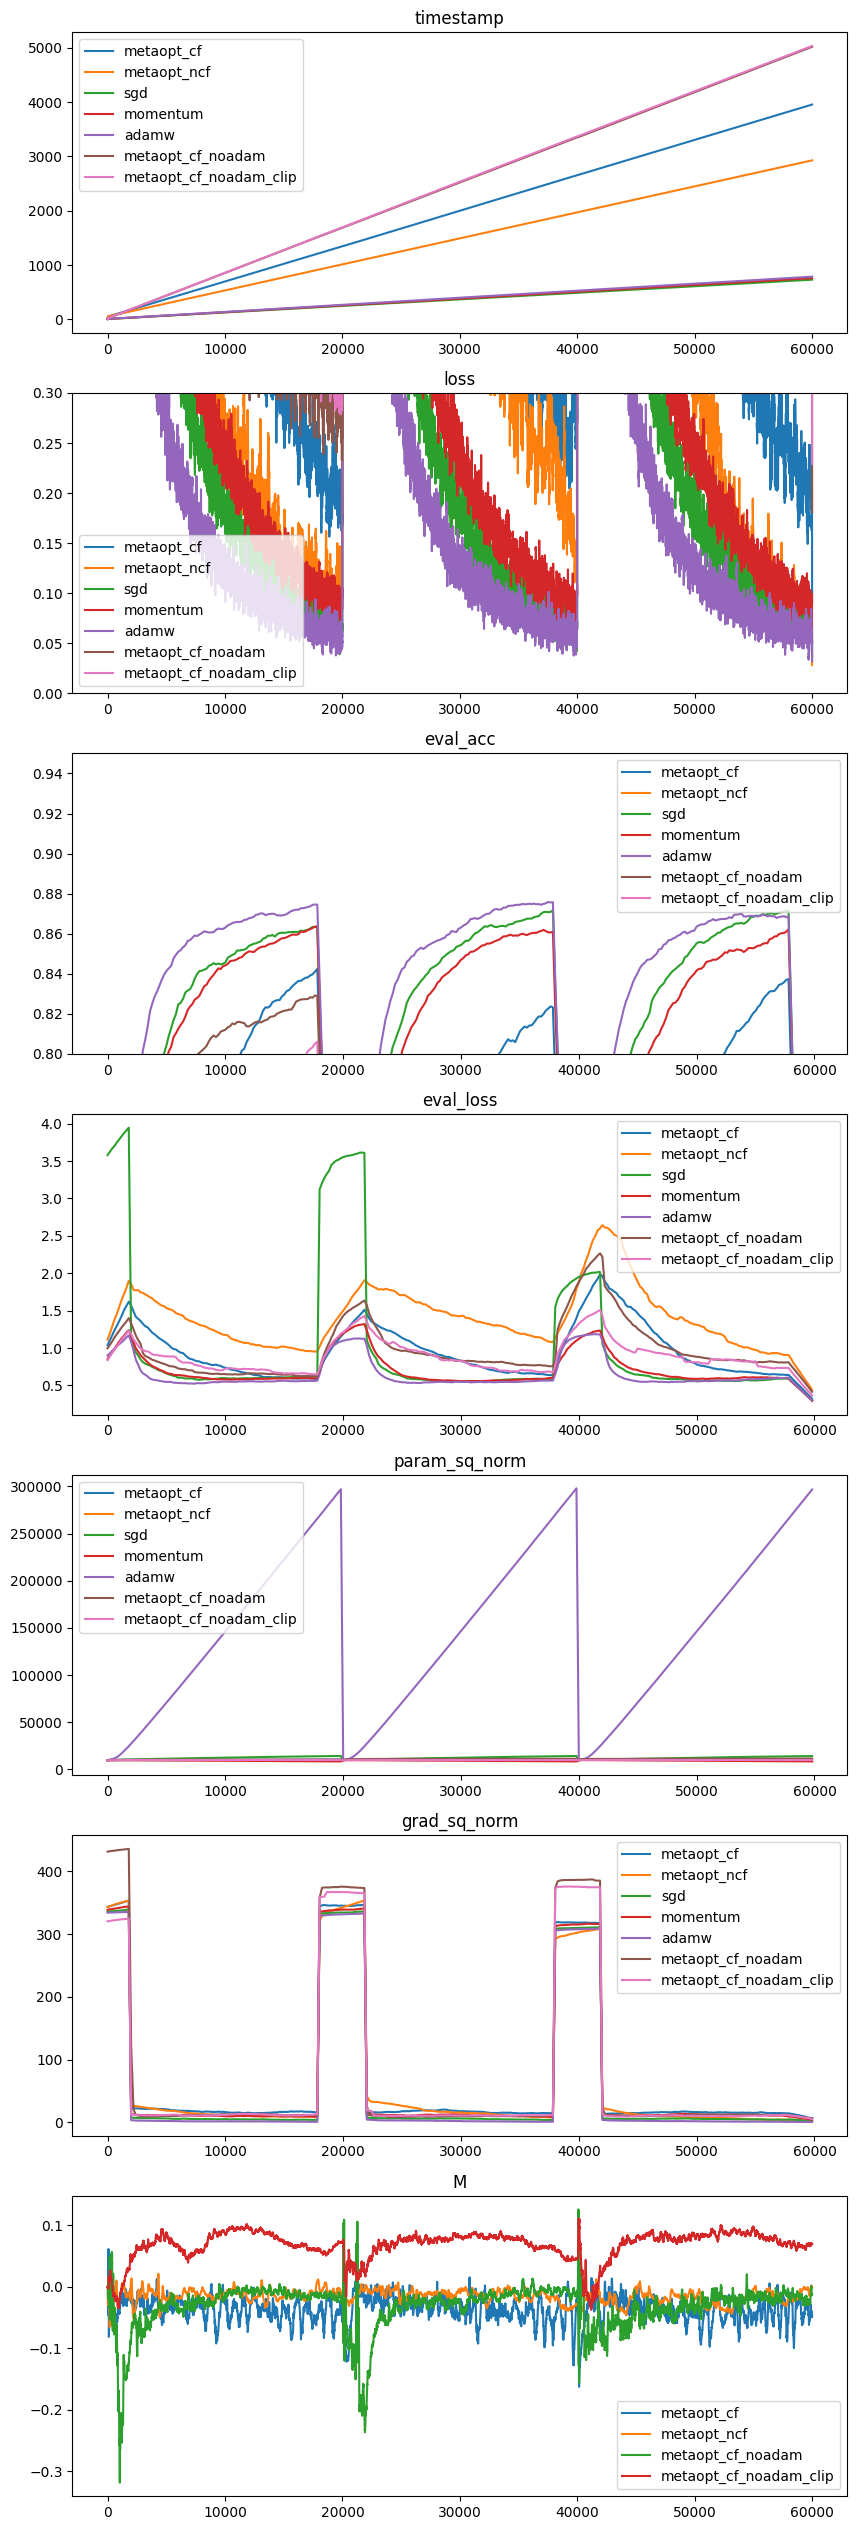

In [8]:
# ----------------------------------------
# plot a particular set of experiments
# ----------------------------------------
# keys_to_plot = [
#     'sgd',
#     'momentum',
#     'adamw',
#     'hgd',
#     'metaopt_cf_long',
#     'metaopt_cf_long_noadam',
#     'metaopt_ncf_long_noadam',
# ]

# ----------------------------------------
# OR just plot em via regex
# ----------------------------------------
# keys_to_plot = '.*long.*'  # specific regex
keys_to_plot = '.*'  # anything

(fig, ax), anim = plot(results, processed_results, keys_to_plot, anim_bounds=(-0.4, 0.1))
ax[1].set_ylim(0., 0.3)
ax[2].set_ylim(0.8, 0.95)
# ax[3].set_ylim(0.5, 0.9)
# ax[4].set_ylim(-0.1, 40)
# ax[5].set_ylim(-0.05, 0.05)
# plt.savefig(f'{DIR}/figs/{CFG['experiment_name']}.pdf')
for a in ax: a.legend()
plt.show()

h = HTML(anim.to_html5_video())
display(h)

In [10]:
results['metaopt_cf_noadam'][0]['args'

dict_keys(['args', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2